# 6.2 - Multi-sourcing under Supply Uncertainty
Prepared by: Nickolas Freeman, PhD

This notebook will demonstrate different approaches to modeling supply uncertainty. This demonstration will utilize a dataset that contains information regarding the sales of three products, each of which has been previously ordered from multiple suppliers. The steps we take to prepare the data for optimization modeling serve as a refresher on the use of Python for data manipulation. The following code block imports several libraries that we will use for the analysis. Note that I am using the `distribution_fitting` module that can be found at https://github.com/nkfreeman/modules.

In [1]:
import pathlib

from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pulp

import OM527_functions as omf

Throughout the notebook, we will use variables to store parameter values as much as possible. The motivation for doing this is to demonstrate how to write code in a form that is amenable to automation with as few changes as possible. The following code block specifies a variable that stores the path to the data file.

In [2]:
data_filename = pathlib.Path('data', 'historical_data.xlsx')

At this point, we are not sure exactly how the Excel file that contains the data is structured. The following code block creates a Pandas `ExcelFile` object using the the data file. This object has several attributes that we may use to gather information regarding the data's structure.

In [3]:
data_file = pd.ExcelFile(data_filename)

The following code block uses the `sheet_names` attribute of the `ExcelFile` object to generate a list of the sheet names contained in the Excel file.

In [4]:
data_file.sheet_names

['sales_data', 'delivery_data', 'price_data']

Suppose that we want to read the data contained in each sheet into a separate Pandas `DataFrame` so that we can view the data and access the contents of the sheets for further analysis. Although Python (or most other programming languages for that matter) do not permit variables to be created *on-the-fly*, Python dictionaries allow us to achieve the same result. Essentially, we can create a dictionary with keys for each worksheet in the Excel file. The value for each key will be the associated data stored as a Pandas `DataFrame`. The following code block creates such a dictionary, which we name `data`.

In [5]:
data = {}
for current_sheet in data_file.sheet_names:
    data[current_sheet] = pd.read_excel(data_filename, 
                                        sheet_name = current_sheet)

The following code block iterates over the `data` object, printing the first three rows of each `DataFrame`.

In [6]:
for key in data.keys():
    print('-'*50)
    print(f'The first entry in the {key} object is:')
    print('-'*50)
    print(data[key].loc[0])
    print('\n')

--------------------------------------------------
The first entry in the sales_data object is:
--------------------------------------------------
Date       2017-08-19 00:00:00
Product                      A
Sales                      806
Name: 0, dtype: object


--------------------------------------------------
The first entry in the delivery_data object is:
--------------------------------------------------
Date                 01/01/2015
Product                       B
Supplier                  Comp6
On_Time                       1
Yield                  0.902671
Unit_Cost                   0.8
Ship_From_Country             3
Name: 0, dtype: object


--------------------------------------------------
The first entry in the price_data object is:
--------------------------------------------------
Product          A
Sales_Price    2.0
Name: 0, dtype: object




# Data Exploration

Before continuing, let's investigate the data to get a better understanding of the different cases we will be modeling. The following code block shows that the data associated with the `sales_data` key contains 1500 sales observations for three products (combined). Note that providing the `all` argument to the `describe` method tells Pandas that we would like to see information for non-numeric columns in addition to numeric columns.

In [7]:
data['sales_data'].describe(include = 'all', datetime_is_numeric = True)

,Date,Product,Sales
count,1500,1500,1500.000000
unique,NaN,3,NaN
top,NaN,A,NaN
freq,NaN,500,NaN
mean,2018-04-25 12:00:00,NaN,860.849333
min,2017-08-19 00:00:00,NaN,259.000000
25%,2017-12-21 18:00:00,NaN,352.000000
50%,2018-04-25 12:00:00,NaN,768.000000
75%,2018-08-28 06:00:00,NaN,1463.000000
max,2018-12-31 00:00:00,NaN,1645.000000


The following code block provides information regarding the data associated with the `delivery_data` key. Using this information, along with the first row printed earlier, it seems that this data includes shipment outcomes for various orders for the available products. In particular, there are 3000 observations for the three products (combined). In total, orders are placed with 16 unique suppliers and the data includes a binary field that represents whether or not each delivery was made *on-time*, the yield assoicated with each delivery, the unit cost charged, and a numeric field representing the country the order shipped from.

In [8]:
data['delivery_data'].describe(include='all')

,Date,Product,Supplier,On_Time,Yield,Unit_Cost,Ship_From_Country
count,3000,3000,3000,3000.000000,3000.000000,3000.000000,3000.000000
unique,1270,3,16,NaN,NaN,NaN,NaN
top,11/19/2017,C,Comp13,NaN,NaN,NaN,NaN
freq,9,1245,368,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.894000,0.831155,1.760477,1.232667
std,NaN,NaN,NaN,0.307889,0.046624,0.797020,0.497275
min,NaN,NaN,NaN,0.000000,0.714098,0.800000,1.000000
25%,NaN,NaN,NaN,1.000000,0.798552,1.180000,1.000000
50%,NaN,NaN,NaN,1.000000,0.833835,1.290000,1.000000
75%,NaN,NaN,NaN,1.000000,0.866595,2.530000,1.000000


The following code block provides insight into the data associated with the `price_data` key. There are only three records, one for each product. Thus, the data seems to be providing the sales price for each product.

In [9]:
data['price_data'].describe(include='all')

,Product,Sales_Price
count,3,3.000000
unique,3,NaN
top,A,NaN
freq,1,NaN
mean,NaN,2.750000
std,NaN,1.984313
min,NaN,1.250000
25%,NaN,1.625000
50%,NaN,2.000000
75%,NaN,3.500000


Since we are interested in modeling supply uncertainty, lets look at the `delivery_data` in more detail. The following code block provides the number of unique values for the *On_Time*, *Yield*, *Unit_Cost*, and *Ship_From_Country* columns, grouped by *Supplier* and *Product*. Apparently, each supplier only provides a single product, charges a fixed unit cost, and ships from a single country. As noted earlier, the *On_Time* column contains only two values, whereas the *Yield* column appears to be continuous.

In [10]:
agg_columns = ['Supplier', 'Product']

agg_dict = {
    'On_Time': ['nunique'],
    'Yield': ['nunique'],
    'Unit_Cost': ['nunique'],
    'Ship_From_Country': ['nunique'],
}

data['delivery_data'].groupby(agg_columns).agg(agg_dict)

,,On_Time,Yield,Unit_Cost,Ship_From_Country
,,nunique,nunique,nunique,nunique
Supplier,Product,,,,
Comp1,A,2,203,1,1
Comp10,B,2,107,1,1
Comp11,B,2,68,1,1
Comp12,B,2,60,1,1
Comp13,C,2,368,1,1
Comp14,C,2,312,1,1
Comp15,C,2,259,1,1
Comp16,C,2,306,1,1


We will be incorporating both the on-time delivery performance and yield for suppliers in our models. For ease of reference, we will create a function later that generates a dictionary we can use to easily access relevant supplier information. The following code block shows how we can use pandas `groupby` method to capture information regarding the product supplied, the mean on-time delivery, the unit cost, and the ship from country for each supplier.

In [11]:
agg_columns = ['Supplier']

agg_dict = {
    'Product': ['first'],
    'On_Time': ['mean'],
    'Yield': ['mean'],
    'Unit_Cost': ['mean'],
    'Ship_From_Country': ['first'],
}

supplier_info = data['delivery_data'].groupby(agg_columns).agg(agg_dict)
supplier_info.columns = ['_'.join(col).strip() for col in supplier_info.columns.values]
supplier_info = supplier_info.to_dict(orient = 'index')
supplier_info

{'Comp1': {'Product_first': 'A',
  'On_Time_mean': 0.8522167487684729,
  'Yield_mean': 0.7721595850178289,
  'Unit_Cost_mean': 1.29,
  'Ship_From_Country_first': 1},
 'Comp10': {'Product_first': 'B',
  'On_Time_mean': 0.9065420560747663,
  'Yield_mean': 0.8224423612623306,
  'Unit_Cost_mean': 0.86,
  'Ship_From_Country_first': 1},
 'Comp11': {'Product_first': 'B',
  'On_Time_mean': 0.9558823529411765,
  'Yield_mean': 0.7665497031120688,
  'Unit_Cost_mean': 0.94,
  'Ship_From_Country_first': 1},
 'Comp12': {'Product_first': 'B',
  'On_Time_mean': 0.8,
  'Yield_mean': 0.8068515339574146,
  'Unit_Cost_mean': 0.82,
  'Ship_From_Country_first': 2},
 'Comp13': {'Product_first': 'C',
  'On_Time_mean': 0.9565217391304348,
  'Yield_mean': 0.8554452575734928,
  'Unit_Cost_mean': 2.8,
  'Ship_From_Country_first': 1},
 'Comp14': {'Product_first': 'C',
  'On_Time_mean': 0.8141025641025641,
  'Yield_mean': 0.7654778524043675,
  'Unit_Cost_mean': 2.53,
  'Ship_From_Country_first': 1},
 'Comp15': {'Pr

We will be constructing stochastic optimization models based on the supplier information. As we saw in the previous class, we can incorprate uncertainty using scenarios. Since the yield is continuous, we can use our parametric or non-parametric methods to fit a distribution and generate the sample. The following code block shows how this can be performed for a particular supplier using kernel density estimation.

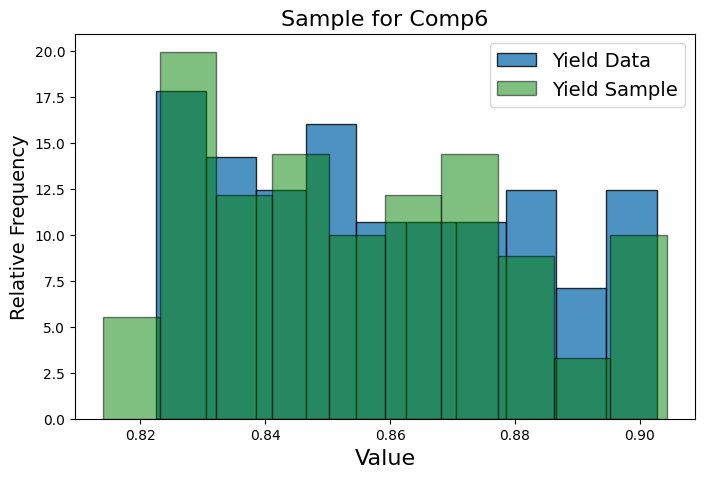

In [12]:
scenarios = 100

current_supplier = 'Comp6'
mask = data['delivery_data']['Supplier'] == current_supplier
yield_vals = data['delivery_data'][mask]['Yield'].values

best_params = omf.distfit.fit_best_kde(yield_vals)
pdf = omf.distfit.pdf_from_kde(yield_vals, 
                               bandwidth = best_params['bandwidth'], 
                               kernel = best_params['kernel'])
yield_sample = omf.distfit.trunc_kde_sample(pdf['x'], 
                                            pdf['y'], 
                                            sample_size = scenarios)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(yield_vals, 
        label = 'Yield Data', 
        alpha = 0.8, 
        edgecolor = 'k', 
        density = True)
ax.hist(yield_sample, 
        label='Yield Sample', 
        alpha = 0.5, 
        color = 'g', 
        edgecolor = 'k', 
        density = True)
ax.set_title(f'Sample for {current_supplier}', fontsize = 16)
ax.set_xlabel('Value', fontsize = 16)
ax.set_ylabel('Relative Frequency', fontsize = 14)
ax.legend(fontsize = 14)
plt.show()

We will use a binomial distribution to generate scenarios for on-time delivery. From https://en.wikipedia.org/wiki/Binomial_distribution (accessed 3/20/2019):

>In probability theory and statistics, the binomial distribution with parameters n and p is the discrete probability distribution of the number of successes in a sequence of n independent experiments, each asking a yes–no question, and each with its own boolean-valued outcome: a random variable containing a single bit of information: success/yes/true/one (with probability p) or failure/no/false/zero (with probability q = 1 − p). A single success/failure experiment is also called a Bernoulli trial or Bernoulli experiment and a sequence of outcomes is called a Bernoulli process; for a single trial, i.e., n = 1, the binomial distribution is a Bernoulli distribution. The binomial distribution is the basis for the popular binomial test of statistical significance.

The following code block shows how we can use Numpy's binomial function to generate 100 scenarios for an example situation where on-time delivery is 80%.

In [13]:
np.random.seed(0)
my_sample = np.random.binomial(n = 1, 
                               p = 0.80, 
                               size = 100)

print(f'The first five values of the sample are {my_sample[:10]}')
print(f'The mean of the sample is {my_sample.mean()}')

The first five values of the sample are [1 1 1 1 1 1 1 0 0 1]
The mean of the sample is 0.85


The following code block generates a 10000 point sample and shows how the values will converge to the true probability as the sample size increases.

In [14]:
np.random.seed(0)
my_sample = np.random.binomial(n = 1, 
                               p = 0.80, 
                               size = 10000)

print(f'The first five values of the sample are {my_sample[:10]}')
print(f'The mean of the sample is {my_sample.mean()}')

The first five values of the sample are [1 1 1 1 1 1 1 0 0 1]
The mean of the sample is 0.8028


The following code block generates an on-time delivery sample for a specified supplier. Note that I am just using the mean on-time delivery value from the `supplier_info` object to define the probability.

In [15]:
scenarios = 100

current_supplier = 'Comp6'
np.random.binomial(n = 1, 
                   p = supplier_info[current_supplier]['On_Time_mean'], 
                   size = scenarios)

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0])

The following code block defines a `create_supplier_info` function that applies the aggregations and distribution fitting methods we have looked at up to this point and returns a dictionary with the supplier info and generated samples. Note that this is just one way of working with the data. In practice, I would also consider how a `class` may be used to handle the supplier and product data, but this is beyond the scope of this course. For more information on classes and object-orieted programming see http://introtopython.org/classes.html (last accessed 3/27/2020). 

In [16]:
def create_supplier_info(delivery_data, scenarios):
    
    agg_columns = ['Supplier']

    agg_dict = {
        'Product': ['first'],
        'On_Time': ['mean'],
        'Yield': ['mean'],
        'Unit_Cost': ['mean'],
        'Ship_From_Country': ['first'],
    }

    supplier_info_dict = data['delivery_data'].groupby(agg_columns).agg(agg_dict)
    supplier_info_dict.columns = ['_'.join(col).strip() for col in supplier_info_dict.columns.values]
    supplier_info_dict = supplier_info_dict.to_dict(orient = 'index')
        
    for current_supplier in supplier_info_dict.keys():
        mask = delivery_data['Supplier'] == current_supplier
        yield_vals = delivery_data.loc[mask, 'Yield'].values

        best_params = omf.distfit.fit_best_kde(yield_vals)
        pdf = omf.distfit.pdf_from_kde(yield_vals, 
                                       bandwidth = best_params['bandwidth'], 
                                       kernel = best_params['kernel'])
        yield_sample = omf.distfit.trunc_kde_sample(pdf['x'], 
                                                     pdf['y'], 
                                                     sample_size = scenarios)
        supplier_info_dict[current_supplier]['Yield_Sample'] = yield_sample
        
    for current_supplier in supplier_info_dict.keys():
        supplier_info_dict[current_supplier]['OTD_Sample'] = (
            np.random.binomial(n = 1,
                               p = supplier_info_dict[current_supplier]['On_Time_mean'],
                               size = scenarios)
        )
        
    return supplier_info_dict

The following code block demonstrates the use of the revised function.

In [17]:
supplier_info = create_supplier_info(data['delivery_data'], 100)

We will now look to construct a function for generating product info, i.e., a dictionary that contains a demand sample and the sales price for each product. The following code block shows how we can convert the data in the `price_data` DataFrame to a dictionary.

In [18]:
price_dict = data['price_data'].set_index('Product').to_dict(orient = 'index')
price_dict

{'A': {'Sales_Price': 2.0},
 'B': {'Sales_Price': 1.25},
 'C': {'Sales_Price': 5.0}}

Using the same technique as we did in the `create_supplier_info` function to fit ditributions, the following code block defines a function to get the desired product data.

In [19]:
def create_product_info(sales_data, price_data, scenarios):
    
    product_info_dict = price_data.set_index('Product').to_dict(orient = 'index')
    
    for current_product in product_info_dict.keys():
        mask = sales_data['Product'] == current_product
        values = sales_data.loc[mask, 'Sales'].values

        best_params = omf.distfit.fit_best_kde(values)
        pdf = omf.distfit.pdf_from_kde(values, 
                                       bandwidth = best_params['bandwidth'], 
                                       kernel = best_params['kernel'])
        sample = omf.distfit.trunc_kde_sample(pdf['x'],
                                              pdf['y'],
                                              sample_size = scenarios)
        product_info_dict[current_product]['Sales_Sample'] = sample        
        
    return product_info_dict

The following code block demonstrates the previously defined function and prints the returned data fro product *A*.

In [20]:
product_info = create_product_info(data['sales_data'], data['price_data'], 100)
product_info['A']

{'Sales_Price': 2.0,
 'Sales_Sample': array([773.03543544, 792.27387387, 779.15675676, 773.03543544,
        755.54594595, 784.4036036 , 757.29489489, 812.38678679,
        829.0018018 , 748.55015015, 800.14414414, 770.41201201,
        775.65885886, 818.50810811, 692.58378378, 696.08168168,
        675.09429429, 805.39099099, 799.26966967, 809.76336336,
        835.12312312, 801.01861862, 761.66726727, 799.26966967,
        702.203003  , 783.52912913, 706.57537538, 823.75495495,
        769.53753754, 753.796997  , 726.68828829, 798.3951952 ,
        760.79279279, 775.65885886, 674.21981982, 780.90570571,
        780.90570571, 780.90570571, 822.88048048, 788.77597598,
        744.17777778, 757.29489489, 789.65045045, 690.83483483,
        787.02702703, 787.02702703, 717.94354354, 703.95195195,
        735.43303303, 745.05225225, 775.65885886, 758.16936937,
        840.36996997, 698.70510511, 717.94354354, 710.07327327,
        785.27807808, 724.93933934, 762.54174174, 724.06486486,
   

# Modeling Uncertain On-time Delivery

We will now use the objects we have created to model a situation with uncertain on-time delivery. We will define a function for this purpose, which will allow us to easily iterate over all of the products. The function will take a current product, and our `supplier_info` and ` product_info` objects as arguments. The following code block shows how we will use the current product and `supplier_info` object to determine the relevant suppliers. 

In [21]:
current_product = 'A'
relevant_suppliers = [supplier for supplier in supplier_info.keys()
                      if current_product == supplier_info[supplier]['Product_first']]
print(f'The supplier for product {current_product} are {relevant_suppliers}')

The supplier for product A are ['Comp1', 'Comp2', 'Comp3', 'Comp4', 'Comp5']


We use the following mathematical model.

<u>Sets</u><br>
$S$ - set of suppliers.<br>
$\Omega$ - set of scenarios.<br>
<br>
<u>Indices</u><br>
$s$ - supplier index, $s \in S$.<br>
$\omega$ - scenario index, $\omega \in \Omega$.<br>
<br>
<u>Parameters</u><br>
$p$ - unit sales price.<br>
$c_{s}$ - unit cost charged by supplier $s$.<br>
$d_{\omega}$ - demand in scenario $\omega$.<br>
$\alpha_{s\omega}$ - 1, if supplier $s$ delivers in scenario $\omega$; $0$, otherwise.<br>
<br>
<u>Variables</u><br>
$Q_{S}$ - amount ordered from supplier $s$.<br>
$S_{\omega}$ - amount sold in scenario $\omega$.<br>

$$\displaystyle Maximize \sum_{\omega \in \Omega}\left(pS_{\omega}- \sum_{s\in S}c_{s}\alpha_{s\omega}Q_{s}\right)\bigg/|\Omega|$$


$$Subject~to,\hspace{7cm}~$$
$$\displaystyle S_{\omega} \leq \sum_{s\in S}\alpha_{s\omega}Q_{s}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \leq d_{\omega}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \geq 0, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle Q_{s} \geq 0,~~~~\forall s \in S.$$

The following code block defines our model for incorporating uncertain on-time delivery.

In [22]:
def solve_OTD_model(current_product, 
                    product_info_dict, 
                    supplier_info_dict):
    
    demand_sample = product_info_dict[current_product]['Sales_Sample']
    sales_price = product_info_dict[current_product]['Sales_Price']
    relevant_suppliers = [supplier for supplier in supplier_info_dict.keys()
                          if current_product == supplier_info_dict[supplier]['Product_first']]
    num_scenarios = len(demand_sample)
    
    prob = pulp.LpProblem("Newsvendor_Problem", pulp.LpMaximize)

    Order = {} 
    for supplier in relevant_suppliers:
        Order[supplier] = pulp.LpVariable(f"Order_from_{supplier}", 
                                          lowBound = 0, 
                                          upBound = None, 
                                          cat = pulp.LpContinuous)

    Sell = {}
    for scenario in range(num_scenarios):
        Sell[scenario] = pulp.LpVariable(f"Sell_in_Scenario_{scenario}", 
                                         lowBound = 0, 
                                         upBound = None, 
                                         cat = pulp.LpContinuous)

    expected_revenue = []
    for scenario in range(num_scenarios):
        expected_revenue.append(sales_price*Sell[scenario])
    expected_revenue = pulp.lpSum(expected_revenue)/num_scenarios

    expected_cost = []
    for scenario in range(num_scenarios): 
        for supplier in relevant_suppliers:
            expected_cost.append(supplier_info_dict[supplier]['Unit_Cost_mean']\
                                 *Order[supplier]\
                                 *supplier_info_dict[supplier]['OTD_Sample'][scenario])
    expected_cost = pulp.lpSum(expected_cost)/num_scenarios

    objective_function = expected_revenue - expected_cost
    prob += objective_function

    for scenario in range(num_scenarios):
        total_delivered = pulp.lpSum([Order[supplier]*supplier_info_dict[supplier]['OTD_Sample'][scenario]
                                      for supplier in relevant_suppliers]) 
        prob += (Sell[scenario] <= total_delivered, f'Sell{scenario} <= Order')

    for scenario in range(num_scenarios):
        prob += (Sell[scenario] <= demand_sample[scenario], f'Sell{scenario} <= Demand{scenario}')
        
    prob.solve()    
       
    solution_dict = {}
    for supplier in relevant_suppliers:
        solution_dict[supplier] = Order[supplier].value()

    return solution_dict

The following code block shows that the function returns a dictionary with the optimal order quantity from each supplier.

In [24]:
solve_OTD_model('A', product_info, supplier_info)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/nicholas/Documents/OM527_Solo/environment/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ce9bb9a13bb04333b7cb0e2e3a42dffd-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/ce9bb9a13bb04333b7cb0e2e3a42dffd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 205 COLUMNS
At line 942 RHS
At line 1143 BOUNDS
At line 1144 ENDATA
Problem MODEL has 200 rows, 105 columns and 631 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 100 (-100) rows, 105 (0) columns and 531 (-100) elements
Perturbing problem by 0.001% of 1.3254 - largest nonzero change 9.5085123e-05 ( 0.0088979955%) - largest zero change 0
0  Obj -0 Dual inf 1.9998214 (100)
77  Obj 497.20879
Optimal - objective value 497.32745
After Postsolve, objective 497.32745, infeasibilities - dual 0 (0), primal 0 (0)
Optimal object

{'Comp1': 28.857658,
 'Comp2': 80.451652,
 'Comp3': 663.72613,
 'Comp4': 0.0,
 'Comp5': 0.0}

The following code block shows how our functions work together to solve the uncertain on-time delivery model for all products.

In [25]:
scenarios = 1000
product_info = create_product_info(data['sales_data'], data['price_data'], scenarios)
supplier_info = create_supplier_info(data['delivery_data'], scenarios)

for current_product in product_info.keys():
    print('-'*50)
    print(f'Product {current_product}')
    print('-'*50)
    solution = solve_OTD_model(current_product, product_info, supplier_info)
    
    for key in solution.keys():
        print(f'Order {solution[key]} from {key}')
    print('\n')

--------------------------------------------------
Product A
--------------------------------------------------
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/nicholas/Documents/OM527_Solo/environment/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/dfa161ff77184c39b5fde1516da62bd7-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/dfa161ff77184c39b5fde1516da62bd7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2005 COLUMNS
At line 9417 RHS
At line 11418 BOUNDS
At line 11419 ENDATA
Problem MODEL has 2000 rows, 1005 columns and 6406 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1000 (-1000) rows, 1005 (0) columns and 5406 (-1000) elements
Perturbing problem by 0.001% of 1.3818 - largest nonzero change 9.506732e-05 ( 0.050653915%) - largest zero change 0
0  Obj -0 Dual inf 1.9982451 (1000)
95  Obj 1362.2987 Primal i

# Yield Uncertainty

We will now consider yield uncertainty using the following mathematical model.

<u>Sets</u><br>
$S$ - set of suppliers.<br>
$\Omega$ - set of scenarios.<br>
<br>
<u>Indices</u><br>
$s$ - supplier index, $s \in S$.<br>
$\omega$ - scenario index, $\omega \in \Omega$.<br>
<br>
<u>Parameters</u><br>
$p$ - unit sales price.<br>
$c_{s}$ - unit cost charged by supplier $s$.<br>
$d_{\omega}$ - demand in scenario $\omega$.<br>
$\beta_{s\omega}$ - yield proportion for supplier $s$ in scenario $\omega$<br>
<br>
<u>Variables</u><br>
$Q_{S}$ - amount ordered from supplier $s$.<br>
$S_{\omega}$ - amount sold in scenario $\omega$.<br>

$$\displaystyle Maximize \sum_{\omega \in \Omega}\left(pS_{\omega}- \sum_{s\in S}c_{s}\beta_{s\omega}Q_{s}\right)\bigg/|\Omega|$$


$$Subject~to,\hspace{7cm}~$$
$$\displaystyle S_{\omega} \leq \sum_{s\in S}\beta_{s\omega}Q_{s}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \leq d_{\omega}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \geq 0, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle Q_{s} \geq 0,~~~~\forall s \in S.$$

The following code block defines our model for incorporating uncertain yield.

In [ ]:
def solve_uncertain_yield_model(current_product, 
                                product_info_dict, 
                                supplier_info_dict):
    
    demand_sample = product_info_dict[current_product]['Sales_Sample']
    sales_price = product_info_dict[current_product]['Sales_Price']
    relevant_suppliers = [supplier for supplier in supplier_info_dict.keys()
                          if current_product == supplier_info_dict[supplier]['Product_first']]
    num_scenarios = len(demand_sample)
    
    prob = pulp.LpProblem("Newsvendor_Problem", pulp.LpMaximize)

    Order = {} 
    for supplier in relevant_suppliers:
        Order[supplier] = pulp.LpVariable(f"Order_from_{supplier}", 
                                          lowBound = 0, 
                                          upBound = None, 
                                          cat = pulp.LpContinuous)

    Sell = {}
    for scenario in range(num_scenarios):
        Sell[scenario] = pulp.LpVariable(f"Sell_in_Scenario_{scenario}", 
                                         lowBound = 0, 
                                         upBound = None, 
                                         cat = pulp.LpContinuous)

    expected_revenue = []
    for scenario in range(num_scenarios):
        expected_revenue.append(sales_price*Sell[scenario])
    expected_revenue = pulp.lpSum(expected_revenue)/num_scenarios

    expected_cost = []
    for scenario in range(num_scenarios): 
        for supplier in relevant_suppliers:
            expected_cost.append(supplier_info_dict[supplier]['Unit_Cost_mean']\
                                 *Order[supplier]\
                                 *supplier_info_dict[supplier]['Yield_Sample'][scenario])
    expected_cost = pulp.lpSum(expected_cost)/num_scenarios

    objective_function = expected_revenue - expected_cost
    prob += objective_function

    for scenario in range(num_scenarios):
        total_delivered = pulp.lpSum([Order[supplier]*supplier_info_dict[supplier]['Yield_Sample'][scenario]
                                      for supplier in relevant_suppliers]) 
        prob += (Sell[scenario] <= total_delivered, f'Sell{scenario} <= Order')

    for scenario in range(num_scenarios):
        prob += (Sell[scenario] <= demand_sample[scenario], f'Sell{scenario} <= Demand{scenario}')
        
    prob.solve()    
       
    solution_dict = {}
    for supplier in relevant_suppliers:
        solution_dict[supplier] = Order[supplier].value()

    return solution_dict

The following code block solves the uncertain yield model for all products.

In [ ]:
scenarios = 1000
product_info = create_product_info(data['sales_data'], data['price_data'], scenarios)
supplier_info = create_supplier_info(data['delivery_data'], scenarios)

for current_product in product_info.keys():
    print('-'*50)
    print(f'Product {current_product}')
    print('-'*50)
    solution = solve_uncertain_yield_model(current_product, product_info, supplier_info)
    
    for key in solution.keys():
        print(f'Order {solution[key]} from {key}')
    print('\n')

# All-or-Nothing Disruptions and Yield Uncertainty

We will now consider both all-or-nothing disruptions and yield uncertainty using the following mathematical model.

<u>Sets</u><br>
$S$ - set of suppliers.<br>
$\Omega$ - set of scenarios.<br>
<br>
<u>Indices</u><br>
$s$ - supplier index, $s \in S$.<br>
$\omega$ - scenario index, $\omega \in \Omega$.<br>
<br>
<u>Parameters</u><br>
$p$ - unit sales price.<br>
$c_{s}$ - unit cost charged by supplier $s$.<br>
$d_{\omega}$ - demand in scenario $\omega$.<br>
$\alpha_{s\omega}$ - 1, if supplier $s$ delivers in scenario $\omega$; $0$, otherwise.<br>
$\beta_{s\omega}$ - yield proportion for supplier $s$ in scenario $\omega$<br>
<br>
<u>Variables</u><br>
$Q_{S}$ - amount ordered from supplier $s$.<br>
$S_{\omega}$ - amount sold in scenario $\omega$.<br>

$$\displaystyle Maximize \sum_{\omega \in \Omega}\left(pS_{\omega}- \sum_{s\in S}c_{s}\alpha_{s\omega}\beta_{s\omega}Q_{s}\right)\bigg/|\Omega|$$


$$Subject~to,\hspace{7cm}~$$
$$\displaystyle S_{\omega} \leq \sum_{s\in S}\alpha_{s\omega}\beta_{s\omega}Q_{s}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \leq d_{\omega}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \geq 0, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle Q_{s} \geq 0,~~~~\forall s \in S.$$

The following code block defines our model for incorporating uncertain yield.

In [ ]:
def solve_uncertain_yield_and_OTD_model(current_product, 
                                product_info_dict, 
                                supplier_info_dict):
    
    demand_sample = product_info_dict[current_product]['Sales_Sample']
    sales_price = product_info_dict[current_product]['Sales_Price']
    relevant_suppliers = [supplier for supplier in supplier_info_dict.keys()
                          if current_product == supplier_info_dict[supplier]['Product_first']]
    num_scenarios = len(demand_sample)
    
    prob = pulp.LpProblem("Newsvendor_Problem", pulp.LpMaximize)

    Order = {} 
    for supplier in relevant_suppliers:
        Order[supplier] = pulp.LpVariable(f"Order_from_{supplier}", 
                                          lowBound = 0, 
                                          upBound = None, 
                                          cat = pulp.LpContinuous)

    Sell = {}
    for scenario in range(num_scenarios):
        Sell[scenario] = pulp.LpVariable(f"Sell_in_Scenario_{scenario}", 
                                         lowBound = 0, 
                                         upBound = None, 
                                         cat = pulp.LpContinuous)

    expected_revenue = []
    for scenario in range(num_scenarios):
        expected_revenue.append(sales_price*Sell[scenario])
    expected_revenue = pulp.lpSum(expected_revenue)/num_scenarios

    expected_cost = []
    for scenario in range(num_scenarios): 
        for supplier in relevant_suppliers:
            expected_cost.append(supplier_info_dict[supplier]['Unit_Cost_mean']\
                                 *Order[supplier]\
                                 *supplier_info_dict[supplier]['Yield_Sample'][scenario]\
                                 *supplier_info_dict[supplier]['OTD_Sample'][scenario])
    expected_cost = pulp.lpSum(expected_cost)/num_scenarios

    objective_function = expected_revenue - expected_cost
    prob += objective_function

    for scenario in range(num_scenarios):
        total_delivered = pulp.lpSum([Order[supplier]*supplier_info_dict[supplier]['OTD_Sample'][scenario]
                                      *supplier_info_dict[supplier]['Yield_Sample'][scenario]
                                      for supplier in relevant_suppliers]) 
        prob += (Sell[scenario] <= total_delivered, f'Sell{scenario} <= Order')

    for scenario in range(num_scenarios):
        prob += (Sell[scenario] <= demand_sample[scenario], f'Sell{scenario} <= Demand{scenario}')
        
    prob.solve()    
       
    solution_dict = {}
    for supplier in relevant_suppliers:
        solution_dict[supplier] = Order[supplier].value()

    return solution_dict

The following code block solves the combined model for all products.

In [ ]:
scenarios = 1000
product_info = create_product_info(data['sales_data'], data['price_data'], scenarios)
supplier_info = create_supplier_info(data['delivery_data'], scenarios)

for current_product in product_info.keys():
    print('-'*50)
    print(f'Product {current_product}')
    print('-'*50)
    solution = solve_uncertain_yield_and_OTD_model(current_product, product_info, supplier_info)
    
    for key in solution.keys():
        print(f'Order {solution[key]} from {key}')
    print('\n')

# Solution Comparison

The following code block demonstrates how our functions and models may be used to solve all variants of the problem for all products and output the results to an Excel file.

In [ ]:
data_filename = pathlib.Path('data', 'historical_data.xlsx')
data_file = pd.ExcelFile(data_filename)
data = {}
for current_sheet in data_file.sheet_names:
    data[current_sheet] = pd.read_excel(data_filename, 
                                        sheet_name = current_sheet)

scenarios = 1000
product_info = create_product_info(data['sales_data'], data['price_data'], scenarios)
supplier_info = create_supplier_info(data['delivery_data'], scenarios)

with pd.ExcelWriter('6.2_output.xlsx') as writer:  

    for current_product in product_info.keys():
        print(f'Starting product {current_product}')
        OTD_solution = solve_OTD_model(current_product, 
                                       product_info, 
                                       supplier_info)
        Yield_solution = solve_uncertain_yield_model(current_product, 
                                                     product_info, 
                                                     supplier_info)
        OTD_and_Yield_solution = solve_uncertain_yield_and_OTD_model(current_product, 
                                                                     product_info, 
                                                                     supplier_info)        
        solution_dict = {}
        for key in OTD_solution.keys():
            solution_dict[key] = {
                'Random_OTD_Solution': OTD_solution[key],
                'Random_Yield_Solution': Yield_solution[key],
                'Random_OTD_and Yield_Solution': OTD_and_Yield_solution[key],
            }

            
        solution_df = pd.DataFrame.from_dict(solution_dict, orient = 'index')
        solution_df = solution_df.reset_index()
        solution_df.to_excel(writer,
                             sheet_name=f'Product_{current_product}',
                             index = False)